In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from datetime import datetime, date

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/maer3/anaconda/envs/mia-stats/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
data = pd.read_csv('biofilm_2018_all.csv')
data.sample(5)

# Add a date column.
data['date'] = pd.to_datetime(data[['year', 'Month', 'day']])
data['date_coded'] = pd.Categorical(data['date']).codes
data['Isolate_coded'] = pd.Categorical(data['Isolate']).codes
data.sample(5)

,Isolate,ST,Replicate,OD600,OD570,reblanked OD,Normalized OD570,Month,day,year,expt,date,date_coded,Isolate_coded
17,16,4,6,0.437,0.198,NaN,0.453089,1,8,2018,1,2018-01-08,0,2
0,11,55,1,0.517,0.097,NaN,0.187621,1,8,2018,1,2018-01-08,0,0
227,11,55,12,0.572,0.245,NaN,0.428322,1,19,2018,5,2018-01-19,3,0
88,46,55,5,0.545,0.118,NaN,0.216514,1,12,2018,3,2018-01-12,2,3
150,11,55,7,0.555,0.124,NaN,0.223423,1,12,2018,4,2018-01-12,2,0


In [23]:
data.describe()

,Isolate,ST,Replicate,OD600,OD570,reblanked OD,Normalized OD570,Month,day,year,expt,date_coded,Isolate_coded
count,288.00000,288.000000,288.00000,288.000000,288.000000,36.000000,288.000000,288.0,288.000000,288.0,288.000000,288.000000,288.000000
mean,43.50000,29.500000,5.75000,0.515125,0.283615,0.328944,0.542376,1.0,13.000000,2018.0,3.371528,1.875000,2.500000
std,33.30819,25.544386,3.37546,0.060809,0.185531,0.315798,0.363239,0.0,3.714554,0.0,1.316270,0.928638,1.710798
min,11.00000,4.000000,1.00000,0.280000,0.057000,0.095333,0.103636,1.0,8.000000,2018.0,1.000000,0.000000,0.000000
25%,13.00000,4.000000,3.00000,0.480000,0.177500,0.163833,0.339337,1.0,11.500000,2018.0,2.750000,1.750000,1.000000
50%,31.00000,29.500000,5.00000,0.512000,0.243500,0.226833,0.452632,1.0,12.000000,2018.0,3.500000,2.000000,2.500000
75%,85.00000,55.000000,8.25000,0.545250,0.331750,0.291083,0.618083,1.0,13.750000,2018.0,4.000000,2.250000,4.000000
max,90.00000,55.000000,12.00000,0.822000,1.438000,1.371333,2.511600,1.0,19.000000,2018.0,5.000000,3.000000,5.000000


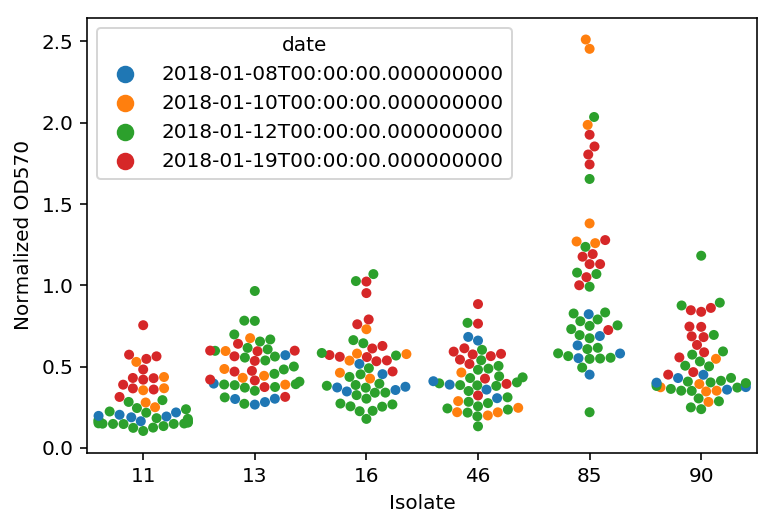

In [17]:
import seaborn as sns
sns.swarmplot(x='Isolate', y='Normalized OD570', hue='date', data=data)

Based on this, there is clear separation between the dates, and thus it is not a reasonable thing to do to pool them together.

In [ ]:
with pm.Model() as nonhierarchical_model:
    shape = len(set(data['Isolate']))
    mu_all = pm.HalfNormal('mu_all', sd=100, shape=(shape,))
    sd_all = pm.Exponential('sd_all', lam=0.5, shape=(shape,))
    nu_all = pm.Exponential('nu', lam=0.5, shape=(shape,))
    mu = mu_all[data['Isolate_coded']]
    sd = sd_all[data['Isolate_coded']]
    nu = nu_all[data['Isolate_coded']]
    like = pm.StudentT('likelihood', mu=mu, sd=sd, nu=nu, observed=data['Normalized OD570'])

In [ ]:
with nonhierarchical_model:
    nonhierarchical_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/anaconda/envs/mia-stats/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):


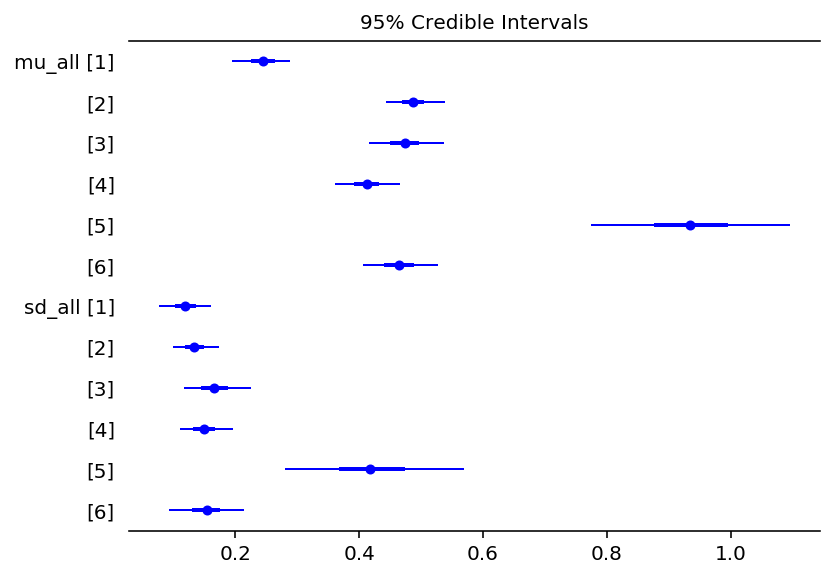

In [55]:
pm.forestplot(trace_lognormal, varnames=['mu_all', 'sd_all'])

In [29]:
# with pm.Model() as halfstudentt_model:
#     shape = len(set(data['Isolate']))
#     nu_all = pm.Exponential('nu_all', lam=0.5, shape=(shape,))
#     sd_all = pm.Exponential('sd_all', lam=0.5, shape=(shape,))
    
#     nu = nu_all[data['Isolate_coded']]
#     sd = sd_all[data['Isolate_coded']]
    
#     like = pm.ChiSquared('like', nu=nu, sd=sd, observed=data['Normalized OD570'])